![title](images/Header__0008_2.png "Header")

In [ ]:
# Installing missing packages.... Run it for the very first time only

# !pip install feather
# !pip install kmodes
# !pip install openpyxl


In [1]:
# Importing the libraries
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
import warnings
import openpyxl
#import feather
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
matplotlib.pyplot.boxplot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from kmodes import kmodes
from kmodes import kprototypes

import scipy.stats as stats
import math

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics.cluster import adjusted_rand_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
# Setting working directory
wd_path = r'D:/ABI Office Work/POC Insights/Korea WS Analysis'
os.chdir(wd_path)

___

## Module 1: Importing Sell-In Data and mergining with flat files

* We are importing quarterly data 
* Filtering out POCs with -ve volumne 

___

In [200]:
# Setting working directory
start =  datetime.now()
pd.set_option('display.max_columns',50)
path = wd_path

#### USER INPUT
YYYY = 2019
QUARTER = 2


# Reading Data
Data1 = pd.read_csv(path+'/Data/sellin_201901_03.csv', sep=';' ,header=None)
Data2 = pd.read_csv(path+'/Data/sellin_201904_06.csv', sep=';' ,header=None)
Data3 = pd.read_csv(path+'/Data/sellin_2019_0708.csv', sep=';' ,header=None)
Data4 = pd.read_csv(path+'/Data/sellin_2019_06.csv', sep=';' ,header=None)
Data5 = pd.read_csv(path+'/Data/sellin_201909.csv', sep=';' ,header=None)
#Data5 = pd.read_csv(path+'/Data/sellin_201801_03.csv', sep=';' ,header=None)
#Data6 = pd.read_csv(path+'/Data/sellin_201804_06.csv', sep=';' ,header=None)
#Data7 = pd.read_csv(path+'/Data/sellin_201807_09.csv', sep=';' ,header=None)
# Data8 = pd.read_csv(path+'/Data/sellin_201810_12.csv', sep=';' ,header=None)
# Data9 = pd.read_csv(path+'/Data/Sell_in_201910.csv', sep=';' ,header=None)

#Data18 = pd.DataFrame(columns=colname)

colname = ['BAR_ID','BIZNUMBER','CUSTOMERNAME','LIQUORTYPE','MLIQUORTYPE',
           'MPRODUCT','MPURCHASER','PRODUCTNAME','REVENUE','YEARMONTH',
           'BIZNUMBERX', 'PRODUCT','VOLUME_1L', 'package','SKU_ID',
           'SKU_COUNT','OUTLETCODE']

df_list = [Data1, Data2, Data3, Data4, Data5]

#Data = pd.DataFrame()
for df in df_list:
    df.columns = colname

Data2 = Data2[(Data2['YEARMONTH'] < 201906)]

# Merging all datasets
Data = pd.DataFrame()
Data = pd.concat([Data1, Data2, Data3, Data4, Data5])

# Removing -ive sales
Data = Data[(Data['VOLUME_1L'] >=0)]
Data['REVENUE'] = np.where(Data['REVENUE']<0 ,0,Data['REVENUE'])
end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:01:15.628753


### Further merging and filteration 

* Mergining MPURCHASER file to make Maker identity 
* With LIQUORTYPE and MLIQUORTYPE, we are tagging categories - Beer, Soju, NAB, Wine and Others
* With WS Org file we are tagging POC geographical characteristics like region, branch etc
* is_comp and is_beer flags help to tag ABI competitor brands/entry and non beer entry/row
___

In [206]:
######************************************************************************
## ***************************************************************************
start =  datetime.now()
# Getting Maker name : MPURCHASER  data
MPurchase = pd.read_csv(path+'/Data/MPURCHASER_CODE.csv')
Data['MPURCHASER'].astype
Data['MPURCHASER'].fillna(0,inplace=True)
Data['MPURCHASER']=Data['MPURCHASER'].astype(int)
# Merging Purchaser data
Data = Data.merge(MPurchase,right_on ='MPURCHASER_CDE',
                          left_on='MPURCHASER', how='left')
# Removing reduntant columns
Data.drop('MPURCHASER_CDE', axis = 1, inplace=True)


Data['LIQUORTYPE'].fillna(0,inplace=True)
Data['LIQUORTYPE']=np.where((Data['LIQUORTYPE']== '#REF!'),
       100000,Data['LIQUORTYPE'])
Data['LIQUORTYPE'] = pd.to_numeric(Data['LIQUORTYPE'], 
       downcast='integer') 
Data['LIQUORTYPE'].unique()

Data['MLIQUORTYPE'].fillna(0,inplace=True)
Data['MLIQUORTYPE'] = pd.to_numeric(Data['MLIQUORTYPE'], 
       downcast='integer') 
Data['MLIQUORTYPE'].unique()

others = [1,2,3,4,6,13]
soju = [7,8]
spirit = [9,10,11,12]
mliqtp = [100,400,200,300]

Data['category_name'] = np.where(
        (Data['LIQUORTYPE'] >=1) & (Data['LIQUORTYPE'] <=13),
        np.where(Data['LIQUORTYPE'].isin(others),'Others',
                 np.where(Data['LIQUORTYPE']==5,'Beer',
                          np.where(Data['LIQUORTYPE']==6,'Wine',
                                   np.where(Data['LIQUORTYPE'].isin(soju),'Soju',
                                            np.where(Data['LIQUORTYPE'].isin(spirit),'Spirit','NAB'))))),
           np.where(Data['MLIQUORTYPE'].isin(mliqtp),
                     np.where(Data['MLIQUORTYPE']==400,'Others',
                              np.where(Data['MLIQUORTYPE'] == 100, 'Beer',
                                       np.where(Data['MLIQUORTYPE']==200,'Soju',
                                                np.where(Data['MLIQUORTYPE']==300,'Spirit','NAB')))),'NAB'))
   
Data['is_comp'] = np.where(Data['Maker_NM']=='OBC',0,1)

Data['is_beer'] = np.where(Data['category_name'] == 'Beer', 0 ,1 )

# ******* New definition of SKU  ****** 

Data['MPRODUCT'] = Data['MPRODUCT'].fillna(0)
false_mproduct = [0, 'nan', ' ',]
Data['MPRODUCT'] = np.where(Data['MPRODUCT'].isin(false_mproduct), Data['PRODUCTNAME'], Data['MPRODUCT'] )
Data['Maker_NM'] = Data['Maker_NM'].fillna("No manufacturer available")

########### MERGING WITH WS DATA 
ws_data = pd.read_excel(path + '/Data/WS_ORG.xlsx')
Data = Data.merge(ws_data[(ws_data['WS_type_cd'] == 10)], right_on = 'BIZNUMBER(WS)', left_on = 'BIZNUMBER')

Data = Data.drop(columns = ['SKU_ID','SKU_COUNT','BIZNUMBERX','PRODUCTNAME','CUSTOMERNAME',
                     'BIZNUMBER(WS)','MLIQUORTYPE','LIQUORTYPE','MPURCHASER','WS_NAME','WS_type_cd','WS_Type_nm'])

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

<bound method NDFrame.astype of 0          20000.0
1          10000.0
2          20000.0
3          20000.0
4          40000.0
            ...   
1520193    20000.0
1520194    20000.0
1520195    20000.0
1520196    40000.0
1520197    10000.0
Name: MPURCHASER, Length: 13019730, dtype: float64>

array([  5,   8,   0,   4,   6,  12,  11,  13,   7,   9,   3,  10,   2,
        14,  15,   1,  60,  20, 999,  21, 950], dtype=int64)

array([100, 200, 500, 400, 300,   0], dtype=int64)

Time lapsed: 0:01:30.510072


### Feature / Metric Engineering

* We are counting SKU at monthly level. As there are multiple entries with same POC-ID, same month, same brand and package, we need to count SKU by counting UNIQUE entry and hence nunique() function
* Rel Distribution of Cass = Total Cass #SKU / (Total beer #SKU in the POC)
* __Note:__ RD of _Cass 500_ and _Cass 350_ donot make sense. __RD__ is always calculated for a __BRAND__

***

In [5]:
# Feature 1: SKU Calculation for each category type 
############## Counting brand SKU at POC level
start =  datetime.now()

Data['SKU_ID'] = np.where(Data['OUTLETCODE']=='K4',Data['PRODUCT'],
                          Data['MPRODUCT'].astype(str).str.cat(Data['package'], sep ='_'))

data_roll = Data.groupby(['BAR_ID', 'YEARMONTH','category_name','MPRODUCT'])['SKU_ID'].nunique().reset_index()
colnames_3 = ['BAR_ID','YEARMONTH','category_name','MPRODUCT','BrandSKU']
data_roll.columns = colnames_3

Data = pd.merge(Data, data_roll, on = ['BAR_ID','YEARMONTH','category_name','MPRODUCT'])

########### Calculating total category SKU at POC level
data_sku_all = Data.groupby(['BAR_ID', 'YEARMONTH','category_name'])['SKU_ID'].nunique().reset_index()
colnames_4 = ['BAR_ID','YEARMONTH','category_name','Total_SKU_Count']
data_sku_all.columns = colnames_4
Data = pd.merge(Data, data_sku_all, on = ['BAR_ID','YEARMONTH','category_name'])

Data['RelDis'] = Data['BrandSKU'] / Data['Total_SKU_Count']

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:35.799047


***

## Module 2: Monthly roll up at POC - Brand - Category - Yearmonth level

* We are rolling up the volume and revenue at POC-MPRODUCT-Monthly level
* In this step, POC having Cass 500 and Cass 350 will have single entry. So volumne of both cass package will be summed up. 

***

In [6]:
# Feature 2: Rolling up the data at Monthly level - total Vol and Revenue at Monthly level 
############## Calculating vol,revenue and PTR POC level
start =  datetime.now()

Data_store = Data.copy()
Data_store = Data_store.drop(columns = ['VOLUME_1L','REVENUE','SKU_ID'])
Data_store = Data_store.drop_duplicates(subset = ['BAR_ID','MPRODUCT','YEARMONTH'])

Data_roll = Data[['BAR_ID','MPRODUCT','YEARMONTH','VOLUME_1L',
                  'REVENUE']].groupby(['BAR_ID',
                                                'MPRODUCT','YEARMONTH'], as_index = False).agg({'VOLUME_1L':['sum'],
                                                                                               'REVENUE':['sum']})
Data_roll.columns = ['BAR_ID','MPRODUCT','YEARMONTH','VOLUME_1L','REVENUE']

Data = Data_store.merge(Data_roll, on = ['BAR_ID','MPRODUCT','YEARMONTH'])

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:19.589587


***

## Module 3: Important - Quarterly roll up at POC - Brand - Category - Quarter level

* We can easily roll up Revenue and Volume at quarterly level
* But Reldistribution needs some thoughts

***

In [7]:
# Feature 3: Rolling up the data at quarterly level
# Rolling up RelDis at quarterly level  = (Sum of Rel Dis in the quater) / 3

start =  datetime.now()

Data_store = Data.copy()
Data_store = Data_store.drop(columns = ['VOLUME_1L','REVENUE','RelDis','YEARMONTH','PRODUCT',
                                        'package','BrandSKU','Total_SKU_Count'])
Data_store = Data_store.drop_duplicates(subset = ['BAR_ID','MPRODUCT'])

Data_SKU = Data.groupby(['BAR_ID','MPRODUCT'])['RelDis'].sum().reset_index()
Data_SKU['RelDis'] = Data_SKU['RelDis']/3

Data_roll = Data[['BAR_ID','MPRODUCT','VOLUME_1L',
                  'REVENUE','BrandSKU',
                  'Total_SKU_Count']].groupby(['BAR_ID',
                                               'MPRODUCT'], as_index = False).agg({'VOLUME_1L':['sum'],'REVENUE':['sum'],
                                                                                   'BrandSKU': ['sum'],'Total_SKU_Count':['sum']})

Data_roll.columns = ['BAR_ID','MPRODUCT','VOLUME_1L','REVENUE','BrandSKU','Total_SKU_Count']

Data = Data_store.merge(Data_roll, on = ['BAR_ID','MPRODUCT'])
Data = Data.merge(Data_SKU, on = ['BAR_ID','MPRODUCT'], how = 'left')

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:16.078938


### Quaterly features generation

* Here we are doing quarterly calculation for other categories - soju, beer, wine etc 
* The same exercise is being done for Cass and Terra seperately to check their pricing index
* And then calculating PTR which is Revenue / Volume 

In [8]:
# Feature 4: Calculating Soju and other category vol and revenue at POC level
# Feature 5: Calculating Soju Revenue to calculate Beer Vs Soju PTR
# Feature 6: Calculating ABI volume and revenue at POC level 

start =  datetime.now()
category_list = Data_store['category_name'].unique()

for cat in category_list:
    Data_cat = Data[Data['category_name'] == cat]
    Data_roll = Data_cat[['BAR_ID','VOLUME_1L','REVENUE']].groupby(['BAR_ID'], as_index = False).agg({'VOLUME_1L':['sum'],
                                                                                                     'REVENUE':['sum']})
    Volname = cat + '_TotalVol'
    Revname = cat + '_TotalRev'
    Data_roll.columns = ['BAR_ID',Volname, Revname]
    Data = Data.merge(Data_roll, on = ['BAR_ID'], how = 'left')
    
Data_roll = Data[(Data['Maker_NM'] =='OBC') & (Data['category_name']=='Beer').groupby(['BAR_ID'])['VOLUME_1L','REVENUE'].sum().reset_index().rename(columns = {'VOLUME_1L':'ABI_Vol','REVENUE':'ABI_Rev'})
Data = Data.merge(Data_roll, on = 'BAR_ID', how = 'left')

Data = Data.fillna(0)

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:21.643748


In [9]:
# Feature 7: Calculating PTR at POC level for each brand
# Feature 8: POC Beer and Soju ratio 
# Feature 9: Beer SOT = Beer Volume / (Total beverage volume)
# Feature 10: ABI Vol share = ABI Vol / (Total beer volume)

start =  datetime.now()

Data['PTR'] = Data['REVENUE'] / Data['VOLUME_1L']
Data['BeerSoju_VolRatio'] = Data['Beer_TotalVol'] / Data['Soju_TotalVol']

Data = Data.fillna(0)
Data['POC_TotalVol'] = Data['Beer_TotalVol'] + Data['NAB_TotalVol'] + Data['Soju_TotalVol'] + Data['Others_TotalVol']+Data['Spirit_TotalVol'] 
Data['POC_TotalRev'] = Data['Beer_TotalRev'] + Data['NAB_TotalRev'] + Data['Soju_TotalRev'] + Data['Others_TotalRev']+Data['Spirit_TotalRev'] 

Data['BeerSOT'] = Data['Beer_TotalVol'] / Data['POC_TotalVol']

Data['SojuSOT'] = Data['Soju_TotalVol'] / Data['POC_TotalVol']

Data['ABIVolShare'] = Data['ABI_Vol'] / Data['Beer_TotalVol']
Data['SojuPTR'] = Data['Soju_TotalRev'] / Data['Soju_TotalVol']
Data['BeerPTR'] = Data['Beer_TotalRev'] / Data['Beer_TotalVol']
Data['BeerSoju_PTRRatio'] = Data['BeerPTR'] / Data['SojuPTR']

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:01.871354


In [10]:
# Feature 11: Cass-Terra PTR Index = Cass PTR / Terra PTR
# Feature 12: Cass-Terra Rel Distribution 

start =  datetime.now()

# Cass-Terra PTR and index in each POC

Data_store = Data[['BAR_ID','MPRODUCT','PTR']]
Data_SKU_df = Data_store[Data_store['MPRODUCT'] == 10020]
Data_SKU_df.columns = ['BAR_ID','MPRODUCT','Cass_PTR']
Data_SKU_df = Data_SKU_df.drop_duplicates(keep = 'first')

Data_SKU = Data_store[Data_store['MPRODUCT'] == 20060]
Data_SKU.columns = ['BAR_ID','MPRODUCT','Terra_PTR']
Data_SKU = Data_SKU.drop_duplicates(keep = 'first')

Data_roll = pd.merge(Data_SKU_df[['BAR_ID','Cass_PTR']], Data_SKU[['BAR_ID','Terra_PTR']], on ='BAR_ID', how = 'outer')
Data_roll = Data_roll.fillna(0)
Data_roll['CassTerra_PTR_Index'] = Data_roll['Cass_PTR'] / Data_roll['Terra_PTR']

Data = Data.merge(Data_roll, on = 'BAR_ID', how = 'left')

# Cass-Terra Relative Distribution in each POC
Data_store = Data[['BAR_ID','MPRODUCT','RelDis']]
Data_SKU_df = Data_store[Data_store['MPRODUCT'] == 10020]
Data_SKU_df.columns = ['BAR_ID','MPRODUCT','Cass_RelDis']
Data_SKU_df = Data_SKU_df.drop_duplicates(keep = 'first')

Data_SKU = Data_store[Data_store['MPRODUCT'] == 20060]
Data_SKU.columns = ['BAR_ID','MPRODUCT','Terra_RelDis']
Data_SKU = Data_SKU.drop_duplicates(keep = 'first')

Data_roll = pd.merge(Data_SKU_df[['BAR_ID','Cass_RelDis']], Data_SKU[['BAR_ID','Terra_RelDis']], on ='BAR_ID', how = 'outer')

Data = Data.merge(Data_roll, on = 'BAR_ID', how = 'left')

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print ('Time lapsed:',t)

Time lapsed: 0:00:10.426999


#### Check 1: What does K1,K2,K3 distribution signify? What is the distribution of volume and ABI market share across these restaurants?
***

In [11]:
### Finding distrubution of K1,K2,K3,K4 restaurants

K_distribution = pd.DataFrame(Data.groupby(['OUTLETCODE'])['BAR_ID'].nunique().reset_index())
K_distribution.columns = ['OUTLETCODE','Count']
K_distribution['Total_Count'] =  K_distribution.Count.sum()
K_distribution['Distribution perc'] = K_distribution['Count'] / K_distribution['Total_Count']

Data_roll = Data[['OUTLETCODE','ABI_Vol', 'ABI_Rev', 'Beer_TotalVol', 'Beer_TotalRev']].groupby(['OUTLETCODE'],
                            as_index=False).agg({'ABI_Vol':['sum'],
                                                 'ABI_Rev': ['sum'],
                                                'Beer_TotalVol': ['sum'],
                                                'Beer_TotalRev': ['sum']})

Data_roll.columns = ['OUTLETCODE','ABI_Vol', 'ABI_Rev', 'Beer_TotalVol', 'Beer_TotalRev']
Data_roll['Total maker Vol'] = Data_roll.ABI_Vol.sum()
Data_roll['Total beer Vol'] = Data_roll.Beer_TotalVol.sum()
Data_roll['Total maker Rev'] = Data_roll.ABI_Rev.sum()
Data_roll['Total beer Rev'] = Data_roll.Beer_TotalRev.sum()

Data_roll = Data_roll.fillna(0)
Data_roll['Total maker Vol perc'] = Data_roll['ABI_Vol'] / Data_roll['Total maker Vol']
Data_roll['Total beer Vol perc'] = Data_roll['Beer_TotalVol'] / Data_roll['Total beer Vol']
Data_roll['Total maker Rev perc'] = Data_roll['ABI_Rev'] / Data_roll['Total maker Rev']
Data_roll['Total beer Rev perc'] = Data_roll['Beer_TotalRev'] / Data_roll['Total beer Rev']

K_distribution = K_distribution.merge(Data_roll, on = 'OUTLETCODE')
K_distribution['ABI_MS'] = K_distribution['ABI_Vol']/ K_distribution['Beer_TotalVol']

K_distribution = K_distribution[['OUTLETCODE','Count','Total_Count','Distribution perc','Total maker Vol perc','Total beer Vol perc',
                                       'Total maker Rev perc','Total beer Rev perc','ABI_MS']]
K_distribution

,OUTLETCODE,Count,Total_Count,Distribution perc,Total maker Vol perc,Total beer Vol perc,Total maker Rev perc,Total beer Rev perc,ABI_MS
0,0,14352,195913,0.073257,0.001483,0.001404,0.001584,0.001524,0.642261
1,K1,111097,195913,0.567073,0.229599,0.208542,0.237690,0.206992,0.669254
2,K2,24406,195913,0.124576,0.115872,0.109516,0.141332,0.135231,0.643149
3,K3,39099,195913,0.199573,0.416384,0.477922,0.388957,0.470163,0.529604
4,K4,6959,195913,0.035521,0.236662,0.202615,0.230437,0.186090,0.710019


### Credit card data: Credit data.

- Credit card data contains information about POC revenue ranking, Male-Female ratio, Revisit ratio, Personal - Corporate credit card users. 

***

In [12]:
# Getting Credit card data
start = datetime.now()

# yearmonth = pd.read_excel(path+'/Data/YearMonth.xlsx')
Data['YYYY'] = YYYY
Data['QUARTER'] = QUARTER
CC_Data = pd.read_csv(path+'/Data/CreditCard2019_jan_to_aug.csv')

Data = Data.merge(CC_Data, left_on = ['BAR_ID','YYYY','QUARTER'],right_on = ['poc_id','YYYY','QUARTER'])

## Getting POC_Type data
Poc_type = pd.read_excel(path+'/Data/POC_BRN_Type.xlsx')

Data =  Data.merge(Poc_type[['PMS_POC_ID','POC Channel']],
                         on = 'PMS_POC_ID',
                         how = 'left')
Data.rename(columns={"POC Channel":"POC_Channel_type"},inplace=True)

# Dropping columns and merging with MPRODUCT file

Data = Data.drop(columns = ['PMS_POC_ID','poc_id','CD_GRADE','TP_GRADE_LEVEL','WRK_DT'])

backupdata = pd.DataFrame()
backupdata = Data.copy()

end = datetime.now()
t = end-start
print('Time lapsed:', t)

0:01:06.718799


In [13]:
###########  Feature engineering on CC data
start = datetime.now()

# Feature 13: Gender ratio
# Feature 14: Age grouping

Data['male_ratio']=Data['M20_RT']+Data['M30_RT']+Data['M40_RT']+Data['M50_RT']+Data['M60_RT']
Data['female_ratio']=Data['F20_RT']+Data['F30_RT']+Data['F40_RT']+Data['F50_RT']+Data['F60_RT']
Data['age_20_to_40']=Data['F20_RT']+Data['F30_RT']+Data['F40_RT']+Data['M20_RT']+Data['M30_RT']+Data['M40_RT']
Data['age_50_to_60']=Data['F50_RT']+Data['F60_RT']+Data['M50_RT']+Data['M60_RT']

end = datetime.now()
t = end-start
print(t)

0:00:00.190442


***

## Module 4:  Features reduction
In this module we will work on feature reductions. The various approach will be:
1. Heuristic: Variables/features make less business sense
2. Business: 
3. Controllable vs Uncontrollable
4. VIF treatment:
5. Correlation matrix: 

***

In [14]:
## BEFORE BEGINNING OF OUR SOT USE CASE ANALYSIS, WE WANT TO FILTER THE BAR_ID WHERE BEER IS PRESENT
## SO OUR DATA WILL BE AT POC, QUARTER, CATEGORY (=BEER) LEVEL

Data_dt = Data.copy()
Data_dt = Data_dt[(Data_dt['category_name'] == 'Beer')]
Data_dt = Data_dt.drop_duplicates(subset = 'BAR_ID', keep = 'first')

In [15]:
##### 1. Heuristic approach
Data_cat = Data_dt.drop(columns = ['RANK_1_AMT_3M','RANK_2_AMT_3M','RANK_3_AMT_3M','RANK_4_AMT_3M','RANK_5_AMT_3M',
                                  'IAD_RT_AMT_3M','RANK_1_AMT_1M','RANK_2_AMT_1M','RANK_3_AMT_1M','RANK_4_AMT_1M',
                                  'RANK_5_AMT_1M','IAD_RT_AMT_1M','RANK_1_CNT_3M','RANK_2_CNT_3M','RANK_3_CNT_3M',
                                  'RANK_4_CNT_3M','RANK_5_CNT_3M','IAD_RT_CNT_3M','RANK_1_CNT_1M','RANK_2_CNT_1M',
                                  'RANK_3_CNT_1M','RANK_4_CNT_1M','RANK_5_CNT_1M','IAD_RT_CNT_1M','CNT_GRADE_STD',
                                  'TP_VOLUME','VOLUME_BEER_OB','VOLUME_BEER_OTHERS','VOLUME_SOJU','VOLUME_OTHERS',
                                  'SOT_BEER_OB','SOT_BEER_OTHERS','SOT_SOJU','SOT_OTHERS','VOLUME_TOTAL','SOT_BEER',
                                  'SOT_OB'])

##### 2. Business approach or duplicate columns
Data_cat = Data_cat.drop(columns = ['Branch_code','region_code','is_comp','is_beer','DAY_07_YN','DAY_30_YN','DAY_90_YN',
                                  'BIZNUMBER','MPRODUCT','OUTLETCODE','category_name','VOLUME_1L','REVENUE','BrandSKU',
                                  'RelDis','YYYY','QUARTER','YYYYMM','PTR'])

In [16]:
##### 3. We will filter only uncontroable variables for our clustering analysis

# list of uncontrolable variables
variable_list = ['Total_SKU_Count','Others_TotalVol','Others_TotalRev','Beer_TotalVol','Beer_TotalRev',
                 'Soju_TotalVol','Soju_TotalRev','NAB_TotalVol','NAB_TotalRev','Spirit_TotalVol','Spirit_TotalRev',
                 'BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','POC_TotalRev','BeerSOT','SojuSOT','ABIVolShare','SojuPTR','Terra_PTR',
                 'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','WE_RT','PERS_RT','CORP_RT',
                 'REVISIT_RT','AMT_ESTIMATE_SALES','POC_Channel_type','region(EN)']

Data_cat = Data_cat[variable_list]

In [17]:
#### 4. Variance Inflation Factor

####  VIF assesses whether factors are correlated to each other (multicollinearity), which could affect 
#### p-values and the model isn’t going to be as reliable. Generally VIF should be less than 10%. 

In [18]:
from sklearn.linear_model import LinearRegression
def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        if ((1 - r_squared) != 0):
            vif = 1/(1 - r_squared)
            vif_dict[exog] = vif
        else:
            vif_dict[exog] = 0

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [19]:
# VIF check for the variables

Data_store = Data_cat.copy()
Data_store=Data_store.replace([np.inf, -np.inf], np.nan)
Data_store.fillna(0,inplace=True)

# exogs1 = ['Total_SKU_Count','Others_TotalVol','Others_TotalRev','Beer_TotalVol','Beer_TotalRev',
#                  'Soju_TotalVol','Soju_TotalRev','NAB_TotalVol','NAB_TotalRev','Spirit_TotalVol','Spirit_TotalRev',
#                  'BeerSoju_VolRatio','BeerSoju_PTRRatio',,'POC_TotalVol','POC_TotalRev','BeerSOT','SojuSOT','ABIVolShare','SojuPTR','Terra_PTR',
#                  'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','WE_RT','PERS_RT','CORP_RT',
#                  'REVISIT_RT','AMT_ESTIMATE_SALES']


Data_store = Data_store[['Total_SKU_Count','Others_TotalVol','Beer_TotalVol','Soju_TotalVol','NAB_TotalVol',
          'Spirit_TotalVol','BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','BeerSOT','SojuSOT','ABIVolShare','SojuPTR','Terra_PTR',
          'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','PERS_RT',
          'REVISIT_RT','AMT_ESTIMATE_SALES']]

exogs1 = ['Total_SKU_Count','Others_TotalVol','Beer_TotalVol','Soju_TotalVol','NAB_TotalVol',
          'Spirit_TotalVol','BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','BeerSOT','SojuSOT','ABIVolShare','SojuPTR','Terra_PTR',
          'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','PERS_RT',
          'REVISIT_RT','AMT_ESTIMATE_SALES']

sklearn_vif(exogs=exogs1, data=Data_store)

,VIF,Tolerance
Total_SKU_Count,1.518702,0.658457
Others_TotalVol,0.000000,0.000000
Beer_TotalVol,0.000000,0.000000
Soju_TotalVol,0.000000,0.000000
NAB_TotalVol,0.000000,0.000000
Spirit_TotalVol,0.000000,0.000000
BeerSoju_VolRatio,1.282012,0.780024
BeerSoju_PTRRatio,1.617772,0.618134
POC_TotalVol,0.000000,0.000000
BeerSOT,15.722122,0.063605


In [20]:
#### Filtered variable

Data_dt = Data_dt[['Total_SKU_Count','Others_TotalVol','Beer_TotalVol','Soju_TotalVol','NAB_TotalVol',
          'Spirit_TotalVol','BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','BeerSOT','SojuSOT','ABIVolShare','SojuPTR','Terra_PTR',
          'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','PERS_RT',
          'REVISIT_RT','AMT_ESTIMATE_SALES','POC_Channel_type','region(EN)','OUTLETCODE','BAR_ID']]

Data_dt=Data_dt.replace([np.inf, -np.inf], np.nan)
Data_dt.fillna(0,inplace=True)


***

## Module 5: Outlier Treatment  

* Rule 1: We will select only one POC type for the analysis. In this case we will work with K1 restaurants 
* Rule 2: We will plot box plot and check the outlier to remove them from our analysis 

***

In [21]:
### Filtering out K1 type restaurants

Data_dt = Data_dt[(Data_dt['OUTLETCODE'] =='K1')]

Analysis for POC_TotalVol

 (-15.72, 5153.932]        96052
(5153.932, 10297.864]       313
(10297.864, 15441.796]       20
(15441.796, 20585.728]        7
(20585.728, 25729.66]         1
Name: POC_TotalVol, dtype: int64


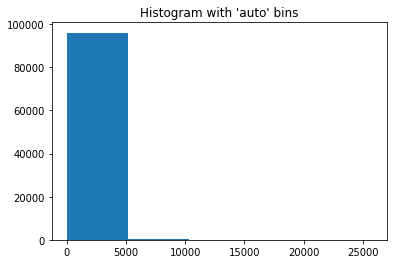

Line plot of POC_TotalVol


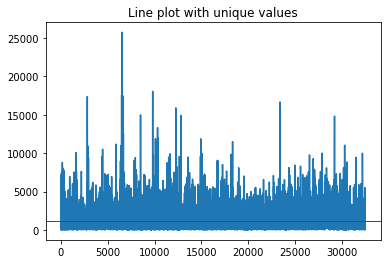

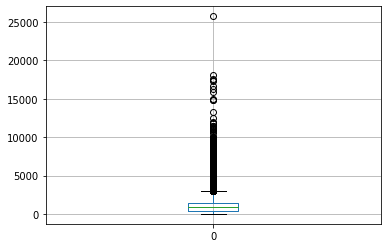

In [22]:
# x = bar_universe2['bar_maker_beer_vol']
# fig, axs = plt.subplots(nrows=1, ncols=3)
def plot_histogram (dataset, colindex):
    if (dataset.iloc[:,colindex].dtypes != 'O'):
        K1_data=dataset
        print('Analysis for',K1_data.columns[colindex])
        print('\n',pd.cut(K1_data.iloc[:,colindex],5).value_counts().sort_index())
        plt.title("Histogram with 'auto' bins")
        plt.hist(K1_data.iloc[:,colindex], bins=5)
        plt.show()
        plt.title("Line plot with unique values")
        print('Line plot of',K1_data.columns[colindex])
        plt.plot(K1_data.iloc[:,colindex].unique())
        threshold = K1_data.iloc[:,colindex].unique().mean()
        plt.axhline(y=threshold,linewidth=1, color='red')
        plt.show()
        df = pd.DataFrame(K1_data.iloc[:,colindex].unique())
        df.boxplot()
    else:
        print ('Can not perform analysis for categorical variable.\nVariable name:', dataset.columns[colindex])

################     bar_universe colnames ###########
# Index(['Total_SKU_Count','Others_TotalVol','Beer_TotalVol','Soju_TotalVol','NAB_TotalVol',
#           'Spirit_TotalVol','BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','BeerSOT','SojuSOT',
#     'ABIVolShare','SojuPTR','Terra_PTR',
#           'CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','PERS_RT',
#           'REVISIT_RT','AMT_ESTIMATE_SALES','POC_Channel_type','region(EN)','OUTLETCODE','BAR_ID']

plot_histogram(Data_dt,8)

Analysis for POC_TotalVol

 (4.856, 1038.88]      79484
(1038.88, 2067.76]    12310
(2067.76, 3096.64]     2915
(3096.64, 4125.52]      999
(4125.52, 5154.4]       345
Name: POC_TotalVol, dtype: int64


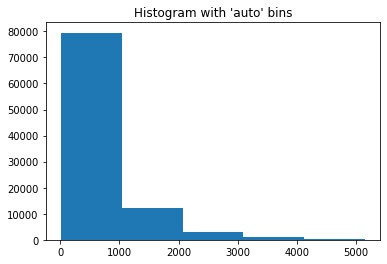

Line plot of POC_TotalVol


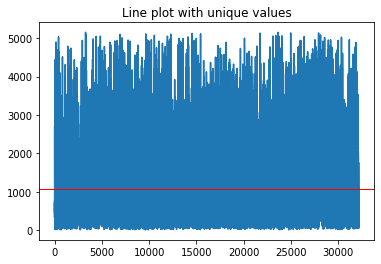

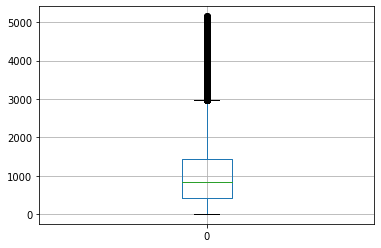

In [25]:
##### Removing Outlier POCs 
# dynamic filters --- should come automatically

Data_store = Data_dt.loc[(Data_dt['POC_TotalVol'] < 5155)]           # 1000 dynamic 
plot_histogram(Data_store,8)

Data_outlier = Data_dt.loc[(Data_dt['POC_TotalVol'] >= 5155)] 

In [195]:
Data_store.BAR_ID.nunique()

96053

***

## Module 6: Clustering using K-Prototype algorithm 
__Literatures__
* http://www.1-4-5.net/~dmm/ml/code/k-prototypes.py
* https://github.com/aryancodify/Clustering
* https://github.com/nicodv/kmodes
* https://rjournal.github.io/archive/2018/RJ-2018-048/RJ-2018-048.pdf
* https://journal.r-project.org/archive/2018/RJ-2018-048/RJ-2018-048.pdf
* https://acadpubl.eu/jsi/2018-118-7-9/articles/7/73.pdf
* https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
* https://www.kaggle.com/rahultej/k-prototypes-correlation-randomforest
* https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914

***

In [26]:
## Update this setting before running the model

verbose = 0                               # kmodes debugging
beer_sot = ['High']                       # Running Analysis for High-High and High-Low analysis

#These are the "categorical" fields in CSV

categorical_field_names = [22]   #dynamic 
numerical_field_names = list(range(22))

init = 'Huang'                    # init can be 'Cao', 'Huang' or 'random'
n_clusters = 4                    # how many clusters (hyper parameter)
max_iter = 100                    # default 100

### strip whitespace (should get this done at export time)

df = Data_store[['Total_SKU_Count','Others_TotalVol','Beer_TotalVol','Soju_TotalVol','NAB_TotalVol','Spirit_TotalVol',
                 'BeerSoju_VolRatio','BeerSoju_PTRRatio','POC_TotalVol','BeerSOT','SojuSOT','ABIVolShare','SojuPTR',
                 'Terra_PTR','CassTerra_PTR_Index','Terra_RelDis','AVG_AMT_3M','AVG_AMT_1M','WK_RT','PERS_RT',
                 'REVISIT_RT','AMT_ESTIMATE_SALES','region(EN)']]

df.rename(columns=lambda x: x.strip(), inplace = True)

### Drop NA and NaN values
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0,inplace=True)

C:\Users\Z100054\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [27]:
# QCing if only numerica fileds getting selected
df.iloc[:,numerical_field_names].head(2)

,Total_SKU_Count,Others_TotalVol,Beer_TotalVol,Soju_TotalVol,NAB_TotalVol,Spirit_TotalVol,BeerSoju_VolRatio,BeerSoju_PTRRatio,POC_TotalVol,BeerSOT,SojuSOT,ABIVolShare,SojuPTR,Terra_PTR,CassTerra_PTR_Index,Terra_RelDis,AVG_AMT_3M,AVG_AMT_1M,WK_RT,PERS_RT,REVISIT_RT,AMT_ESTIMATE_SALES
1,6,15.0,250.0,432.0,0.0,0.0,0.578704,0.872045,697.0,0.358680,0.619799,0.56,3390.138889,2854.6,1.063652,0.5,34918,35159,36.6,95.0,19.6,40328400
6,3,0.0,160.0,172.8,0.0,0.0,0.925926,0.846749,332.8,0.480769,0.519231,1.00,3585.833333,0.0,0.000000,0.0,49927,49225,49.8,96.6,15.0,46766270


In [28]:
# QCing if only categorical fileds getting selected
df.iloc[:,categorical_field_names].head(2)

,region(EN)
1,Seoul
6,Seoul


In [29]:
##### Subsetting data data

# df = df.loc[(df.beer_SoT_grp.isin(beer_sot))]
# df = df.drop(columns = ['beer_SoT_grp','ABI_SoT_grp','TC_flag'])

##### Keeping original data backup

df2 = df.copy()

In [30]:
## Scalling the data. We have two methods written down.

# df = scaler.fit_transform(df.iloc[:,0:19])   #Keep this line commented if using below method

df.iloc[:,numerical_field_names] = df.iloc[:,numerical_field_names].apply(lambda x: (x - x.mean()) / np.std(x))
df.head()

,Total_SKU_Count,Others_TotalVol,Beer_TotalVol,Soju_TotalVol,NAB_TotalVol,Spirit_TotalVol,BeerSoju_VolRatio,BeerSoju_PTRRatio,POC_TotalVol,BeerSOT,SojuSOT,ABIVolShare,SojuPTR,Terra_PTR,CassTerra_PTR_Index,Terra_RelDis,AVG_AMT_3M,AVG_AMT_1M,WK_RT,PERS_RT,REVISIT_RT,AMT_ESTIMATE_SALES,region(EN)
1,0.495086,0.280311,0.015347,0.167077,-0.047615,-0.061068,-0.136203,0.157072,0.121635,-0.262398,0.203807,-1.045619,-0.069167,0.994855,1.067170,1.710732,-0.179104,-0.186968,0.206914,0.468990,0.194499,-0.047908,Seoul
6,-0.365675,-0.218983,-0.284588,-0.451358,-0.047615,-0.061068,-0.030916,-0.010487,-0.418590,0.413188,-0.339525,0.819333,0.107526,-0.976357,-0.953596,-0.839533,0.002760,0.018834,0.994658,0.586705,-0.121844,-0.005160,Seoul
14,0.495086,-0.218983,-0.084632,-0.296749,-0.047615,-0.061068,-0.030916,-0.016357,-0.233472,0.413188,-0.339525,-0.529290,0.107526,1.032490,1.065035,1.710732,-0.154398,-0.153697,-0.216796,0.373346,0.036328,-0.053393,Seoul
31,0.495086,-0.218983,-0.284588,-0.322517,-0.047615,-0.061068,-0.097765,0.330839,-0.338491,0.041783,0.023092,-1.035023,-0.158102,0.994855,1.067170,1.710732,0.009339,-0.020085,-0.210829,0.601420,0.318285,-0.159675,Seoul
34,1.068926,-0.218983,0.081999,-0.116372,-0.047615,-0.061068,-0.050279,-0.085860,-0.047167,0.314656,-0.243325,-0.279545,0.100711,0.994855,1.067170,1.144007,-0.121779,-0.113359,-1.279057,0.358631,-0.768283,-0.230304,Seoul


In [31]:
### Get the model
# from kmodes import kmodes
# from kmodes import kprototypes

start = datetime.now()

data_cats_matrix = df.as_matrix()
kproto = kprototypes.KPrototypes(n_clusters=n_clusters,init=init,verbose=verbose)
clusters = kproto.fit_predict(data_cats_matrix,categorical=categorical_field_names)

# Adding the predicted clusters to the main dataset
df2['cluster_id'] = clusters

# Checking the clusters created
datasetdf = pd.DataFrame(df2['cluster_id'].value_counts())
print (datasetdf)

print("\n")
print('Cluster cost = ', kproto.cost_)

df2.to_csv('ClusteringData_V2.csv', index= False, encoding = 'utf_8_sig')

# print("\n")
# sns.barplot(x=datasetdf.index, y=datasetdf['cluster_id'])

end = datetime.now()
t = end-start
print('TIme lapsed:', t)

C:\Users\Z100054\AppData\Local\conda\conda\envs\Python 3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


   cluster_id
1       46392
0       38866
2        8439
3        2356


Cluster cost =  1516391.6627693567
TIme lapsed: 0:51:32.067427


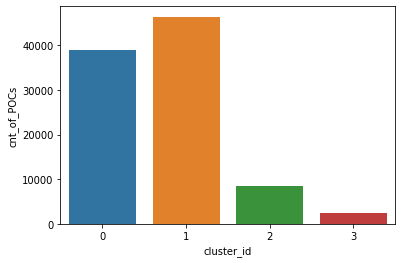

In [32]:
cluster_dist = df2.groupby('cluster_id').size().reset_index(name='cnt_of_POCs')
sns.barplot(x=cluster_dist['cluster_id'], y=cluster_dist['cnt_of_POCs'])

In [104]:
#### Choosing optimal K - This is a cost function and will give an optimum number of clusters where cost is lowest
# cost = []
# data_cats_matrix = df.as_matrix()
# for num_clusters in list(range(1,6)):
#     kproto = kprototypes.KPrototypes(n_clusters=num_clusters,init=init,verbose=verbose)
#     kproto.fit_predict(data_cats_matrix,categorical=categorical_field_names)
#     cost.append(kproto.cost_)
    
# plt.plot(cost)


***

## Module 7: High-High Vs Low-Low Matrix

* We filter High-High POCs and High-Low POCs and then run a classification model.

***

In [33]:
### Merging cluster id back to the original data and then consider High vs Low SOT 

Data_store['cluster_id'] = clusters
df = Data_store[['BAR_ID','cluster_id']]

Data_classification = pd.merge(Data, df, on = 'BAR_ID')
Data_classification = Data_classification.drop_duplicates(subset = 'BAR_ID', keep = 'first')

C:\Users\Z100054\AppData\Local\conda\conda\envs\Python 3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


***

![alt text](Images/SOT_Matrix.png "SOT vs ABI Volume share matrix")

___

In [199]:
# Finding range to define High and Low SOT or ABI Share of Beer

df2 = Data_classification[['BAR_ID','ABI_Vol','Cass_PTR','CassTerra_PTR_Index','Cass_RelDis','WK_RT',
                          'WE_RT','F20_RT','F30_RT','F40_RT','F50_RT','F60_RT','M20_RT','M30_RT','M40_RT','M50_RT',
                          'M60_RT','male_ratio','female_ratio','age_20_to_40','age_50_to_60','TIME_0510_RT','TIME_1114_RT',
                           'TIME_1517_RT','TIME_1819_RT','TIME_2021_RT','TIME_2224_RT','TIME_0104_RT','cluster_id',
                          'ABIVolShare','BeerSOT','AMT_ESTIMATE_SALES']]

df2 = df2[(df2['cluster_id']==1)]

Data_roll = df2[['ABIVolShare','BeerSOT','AMT_ESTIMATE_SALES']]
def_percentiles = [.1,.2,.25,.33,.5,.75,.9,1]
Data_roll.describe (percentiles = def_percentiles)

,ABIVolShare,BeerSOT,AMT_ESTIMATE_SALES
count,46392.000000,46392.000000,4.639200e+04
mean,0.938643,0.367910,3.073370e+07
std,0.176376,0.168297,4.438119e+07
min,0.000000,0.008606,5.600000e+01
10%,0.773447,0.180636,2.320416e+06
20%,1.000000,0.235849,4.750592e+06
25%,1.000000,0.248509,6.142660e+06
33%,1.000000,0.282124,8.751570e+06
50%,1.000000,0.338983,1.584746e+07
75%,1.000000,0.459108,3.653081e+07


In [66]:
chk = pd.DataFrame(Data_classification.columns)
chk.to_csv('chk_col.csv')

In [181]:
import warnings
warnings.filterwarnings("ignore")

var1 = df2['ABIVolShare'].quantile(0.75)
var2 = df2['BeerSOT'].quantile(0.10)
var3 = df2['AMT_ESTIMATE_SALES'].quantile(0.50)

df2['ABIVolShare_grp']=np.where(df2['ABIVolShare'] > var1 ,'High','Low')
df2['BeerSOT_grp']=np.where(df2['BeerSOT'] > var2 ,'High','Low')
df2['Revenue_grp']=np.where(df2['AMT_ESTIMATE_SALES'] > var3 ,'High','Low')

dist3 = df2.groupby(['BeerSOT_grp','ABIVolShare_grp']).size().reset_index(name="cnt_POCs")
dist3 = dist3.pivot_table(index=['BeerSOT_grp'], columns='ABIVolShare_grp', values='cnt_POCs').fillna(0).reset_index()
print ("Distribution of POCs basis Beer SoT and ABI Volumne Share",'\n',dist3)

Distribution of POCs basis Beer SoT and ABI Volumne Share 
 ABIVolShare_grp BeerSOT_grp  High  Low
0                      High  1275  845
1                       Low   138   98


In [182]:
##### Filtering for High-High and High-Low group
##### Filtering cluster 0 for the analysis 

Data_dt = df2[(df2['BeerSOT_grp'] == 'High') & (df2['ABIVolShare_grp'].isin (['High','Low'])) & (df2['Revenue_grp'] == 'High')]

Data_dt['TC_flag'] = np.where((Data_dt['BeerSOT_grp'] == 'High') & (Data_dt['ABIVolShare_grp'] == 'High'), 1, 0)

Data_dt = Data_dt.replace([np.inf, -np.inf], np.nan)
Data_dt.fillna(0,inplace=True)
Data_dt.head()

,BAR_ID,ABI_Vol,Cass_PTR,CassTerra_PTR_Index,Cass_RelDis,WK_RT,WE_RT,F20_RT,F30_RT,F40_RT,F50_RT,F60_RT,M20_RT,M30_RT,M40_RT,M50_RT,M60_RT,male_ratio,female_ratio,age_20_to_40,age_50_to_60,TIME_0510_RT,TIME_1114_RT,TIME_1517_RT,TIME_1819_RT,TIME_2021_RT,TIME_2224_RT,TIME_0104_RT,cluster_id,ABIVolShare,BeerSOT,AMT_ESTIMATE_SALES,ABIVolShare_grp,BeerSOT_grp,Revenue_grp,TC_flag
965,211001-00000005243,40.0,2818.4,0.000000,0.333333,13.9,86.1,21.4,9.7,13.6,10.7,1.1,13.5,12.5,11.1,5.0,1.3,43.4,56.5,81.8,18.1,0.0,46.4,8.9,35.4,9.3,0.0,0.0,3,0.400000,1.000000,57907290,Low,High,High,0
1097,211001-00000005375,30.0,3036.3,0.000000,1.000000,27.0,73.0,4.4,15.2,17.0,3.7,3.4,10.1,24.6,11.7,5.5,4.4,56.3,43.7,83.0,17.0,0.0,51.4,16.1,25.9,6.6,0.0,0.0,3,1.000000,0.750000,22520512,High,High,High,1
1139,211001-00000006329,20.0,3000.2,0.000000,0.333333,6.5,93.5,12.9,14.2,9.0,12.5,1.8,6.5,15.1,20.9,4.5,2.4,49.4,50.4,78.6,21.2,0.0,87.9,7.2,4.8,0.0,0.0,0.0,3,1.000000,1.000000,19843936,High,High,High,1
1940,211001-00000006390,20.0,3036.3,0.000000,0.500000,29.1,70.9,8.3,12.1,29.1,10.9,4.5,1.1,7.2,10.8,11.3,4.6,35.0,64.9,68.6,31.3,3.1,44.9,3.9,24.4,23.8,0.0,0.0,3,0.716332,0.861197,54138343,High,High,High,1
2217,211001-00000014181,10.0,2945.6,1.065818,0.111111,10.9,89.1,24.8,6.6,9.8,9.3,1.1,22.8,6.1,10.6,8.5,0.6,48.6,51.6,80.7,19.5,0.2,45.8,1.6,37.8,14.6,0.0,0.0,3,0.250000,1.000000,23008384,Low,High,High,0


In [183]:
# VIF check for the variables

Data_cat = Data_dt.replace([np.inf, -np.inf], np.nan)
Data_cat.fillna(0,inplace=True)

exogs1 = ['ABI_Vol','Cass_PTR','CassTerra_PTR_Index','Cass_RelDis','WK_RT',
                          'WE_RT','F20_RT','F30_RT','F40_RT','F50_RT','F60_RT','M20_RT','M30_RT','M40_RT','M50_RT',
                          'M60_RT','male_ratio','female_ratio','age_20_to_40','age_50_to_60','TIME_0510_RT','TIME_1114_RT',
                           'TIME_1517_RT','TIME_1819_RT','TIME_2021_RT','TIME_2224_RT','TIME_0104_RT']

Data_cat = Data_cat[['CassTerra_PTR_Index','Cass_RelDis','WK_RT',
                          'F20_RT','F30_RT','F40_RT','F50_RT','F60_RT','M20_RT','M30_RT','M40_RT','M50_RT',
                          'M60_RT','male_ratio','female_ratio','age_20_to_40','age_50_to_60','TIME_0510_RT','TIME_1114_RT',
                           'TIME_1517_RT','TIME_1819_RT','TIME_2021_RT']]

exogs1 = ['CassTerra_PTR_Index','Cass_RelDis','WK_RT',
                          'F20_RT','F30_RT','F40_RT','F50_RT','F60_RT','M20_RT','M30_RT','M40_RT','M50_RT',
                          'M60_RT','male_ratio','female_ratio','age_20_to_40','age_50_to_60','TIME_0510_RT','TIME_1114_RT',
                           'TIME_1517_RT','TIME_1819_RT','TIME_2021_RT']

sklearn_vif(exogs=exogs1, data=Data_cat)

,VIF,Tolerance
CassTerra_PTR_Index,1.023896,0.976661
Cass_RelDis,1.168730,0.855630
WK_RT,1.330002,0.751879
F20_RT,0.000000,0.000000
F30_RT,0.000000,0.000000
F40_RT,0.000000,0.000000
F50_RT,0.000000,0.000000
F60_RT,0.000000,0.000000
M20_RT,0.000000,0.000000
M30_RT,0.000000,0.000000


In [184]:
#### Adding columns from above VIF treatement and TC Flag (High-Low flag)

Data_class_model = Data_dt[['TC_flag','CassTerra_PTR_Index','Cass_RelDis','WK_RT',
                          'F20_RT','F30_RT','F40_RT','F50_RT','F60_RT','M20_RT','M30_RT','M40_RT','M50_RT',
                          'M60_RT','male_ratio','female_ratio','age_20_to_40','age_50_to_60','TIME_0510_RT','TIME_1114_RT',
                           'TIME_1517_RT','TIME_1819_RT','TIME_2021_RT']]
Data_class_model.head()
Data_class_model.shape

,TC_flag,CassTerra_PTR_Index,Cass_RelDis,WK_RT,F20_RT,F30_RT,F40_RT,F50_RT,F60_RT,M20_RT,M30_RT,M40_RT,M50_RT,M60_RT,male_ratio,female_ratio,age_20_to_40,age_50_to_60,TIME_0510_RT,TIME_1114_RT,TIME_1517_RT,TIME_1819_RT,TIME_2021_RT
965,0,0.000000,0.333333,13.9,21.4,9.7,13.6,10.7,1.1,13.5,12.5,11.1,5.0,1.3,43.4,56.5,81.8,18.1,0.0,46.4,8.9,35.4,9.3
1097,1,0.000000,1.000000,27.0,4.4,15.2,17.0,3.7,3.4,10.1,24.6,11.7,5.5,4.4,56.3,43.7,83.0,17.0,0.0,51.4,16.1,25.9,6.6
1139,1,0.000000,0.333333,6.5,12.9,14.2,9.0,12.5,1.8,6.5,15.1,20.9,4.5,2.4,49.4,50.4,78.6,21.2,0.0,87.9,7.2,4.8,0.0
1940,1,0.000000,0.500000,29.1,8.3,12.1,29.1,10.9,4.5,1.1,7.2,10.8,11.3,4.6,35.0,64.9,68.6,31.3,3.1,44.9,3.9,24.4,23.8
2217,0,1.065818,0.111111,10.9,24.8,6.6,9.8,9.3,1.1,22.8,6.1,10.6,8.5,0.6,48.6,51.6,80.7,19.5,0.2,45.8,1.6,37.8,14.6


(1010, 23)

***

## Module 8: Classification using XGBoost

* The idea behind this step is to identify the important features that differentiate these POCs. 
* We will select top 4-5 features 

***

In [185]:
#Xgboost 
import xgboost as xgb

start = datetime.now()
#splitting the dataset
X, y = Data_class_model.iloc[:,1:22],Data_class_model.iloc[:,0]

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


poc_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.03,n_jobs=-1,
                max_depth =6, alpha =10, n_estimators = 200)


poc_model.fit(X_train, y_train)

end = datetime.now()
t = end-start
print('Time lapsed:', t)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Time lapsed: 0:00:00.187499


In [186]:
#Evaluating training performance
X_train_pred=poc_model.predict(X_train)
print(confusion_matrix(y_train,X_train_pred))

print(classification_report(y_train,X_train_pred))

[[411   3]
 [  3 492]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       414
           1       0.99      0.99      0.99       495

    accuracy                           0.99       909
   macro avg       0.99      0.99      0.99       909
weighted avg       0.99      0.99      0.99       909



In [187]:
#Evaluating the performance on test data
X_test_pred=poc_model.predict(X_test)
print(confusion_matrix(y_test,X_test_pred))

print(classification_report(y_test,X_test_pred))

[[31  7]
 [ 3 60]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        38
           1       0.90      0.95      0.92        63

    accuracy                           0.90       101
   macro avg       0.90      0.88      0.89       101
weighted avg       0.90      0.90      0.90       101



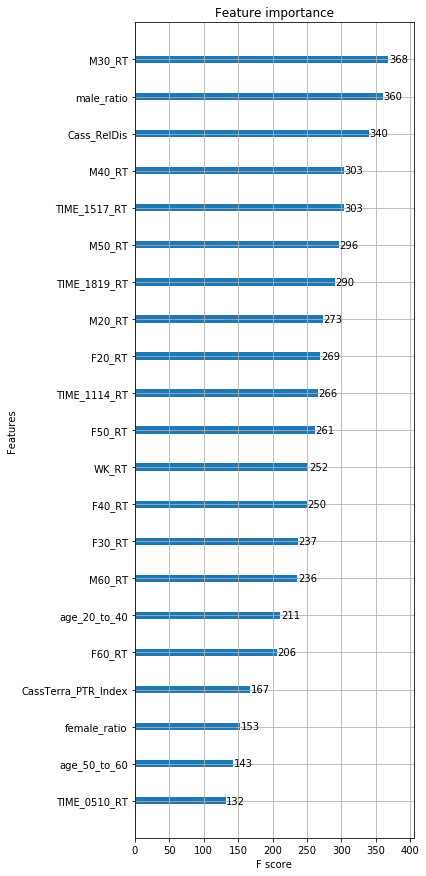

In [188]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

# plot feature importance
plot_importance(poc_model) 
plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [142]:
# Finding difference between clusters
# High-High: 1, High-Low: 0
Data_class_model.groupby('TC_flag')['F30_RT'].mean()


TC_flag
0    10.551153
1     7.791783
Name: F30_RT, dtype: float64

***

## Module 9: Building Recommendation N=1 

* Once we identify the top 5 variables that carry high importance, we will do indexing on them. 
* Example: POC1 belongs to High Beer SOT and Low ABI VolShare (High - Low) bucket. 
* POC1 Variable1 Index = (POC1 Variable1) / (Average of Variable 1 of all High-High POCs)


- __STEP 1:__ Subset the POCs with High-Low flag
- __STEP 2:__ Calculate average of all POCs with High-High flag
- __STEP3:__ Calculate index

***

In [106]:
# Data_classification
# Data_class_model.columns
# poc_model

In [189]:
#### Subsetting the POCs with High -Low flag
Data_POC_recos = Data_class_model[(Data_class_model['TC_flag'] == 0)]
Data_POC_recos_leaders = Data_class_model[(Data_class_model['TC_flag'] == 1)]

#### Getting average

var1_average = Data_POC_recos_leaders['WK_RT'].mean()
var2_average = Data_POC_recos_leaders['F30_RT'].mean()
var3_average = Data_POC_recos_leaders['TIME_1517_RT'].mean()
var4_average = Data_POC_recos_leaders['M30_RT'].mean()

#### Calculating index for each POC with High-Low flag

Data_POC_recos['Index_WK_RT'] = Data_POC_recos['WK_RT'] / var1_average
Data_POC_recos['Index_F30_RT'] = Data_POC_recos['F30_RT'] / var2_average
Data_POC_recos['Index_TIME_1517_RT'] = Data_POC_recos['TIME_1517_RT'] / var3_average
Data_POC_recos['Index_M30_RT'] = Data_POC_recos['M30_RT'] / var4_average

Data_POC_recos.head()

,TC_flag,CassTerra_PTR_Index,Cass_RelDis,WK_RT,F20_RT,F30_RT,F40_RT,F50_RT,F60_RT,M20_RT,M30_RT,M40_RT,M50_RT,M60_RT,male_ratio,female_ratio,age_20_to_40,age_50_to_60,TIME_0510_RT,TIME_1114_RT,TIME_1517_RT,TIME_1819_RT,TIME_2021_RT,Index_WK_RT,Index_F30_RT,Index_TIME_1517_RT,Index_M30_RT
965,0,0.000000,0.333333,13.9,21.4,9.7,13.6,10.7,1.1,13.5,12.5,11.1,5.0,1.3,43.4,56.5,81.8,18.1,0.0,46.4,8.9,35.4,9.3,0.397236,0.986746,0.738600,0.840432
2217,0,1.065818,0.111111,10.9,24.8,6.6,9.8,9.3,1.1,22.8,6.1,10.6,8.5,0.6,48.6,51.6,80.7,19.5,0.2,45.8,1.6,37.8,14.6,0.311502,0.671394,0.132782,0.410131
2290,0,1.063652,0.277778,12.6,5.5,14.0,16.8,7.2,27.1,1.9,3.8,9.4,9.6,4.7,29.4,70.6,51.4,48.6,0.0,47.0,20.4,23.1,9.5,0.360085,1.424170,1.692971,0.255491
3069,0,0.000000,0.166667,21.9,80.9,3.3,3.0,2.5,1.0,3.3,0.0,1.1,4.7,0.2,9.3,90.7,91.6,8.4,1.3,40.0,22.6,25.6,9.1,0.625862,0.335697,1.875547,0.000000
3305,0,0.000000,0.333333,10.2,27.9,23.4,10.4,3.2,1.4,9.1,14.0,7.9,2.6,0.1,33.7,66.3,92.7,7.3,0.0,76.5,4.1,14.6,4.9,0.291497,2.380399,0.340254,0.941284


In [190]:
#### Merging the BAR-ID from the datasets

Data_BAR = Data_dt[(Data_dt['TC_flag'] == 0)]
Data_BAR = pd.DataFrame(Data_BAR['BAR_ID'])

Data_POC_recos = pd.concat ([Data_POC_recos.reset_index(drop = True), Data_BAR.reset_index(drop = True)], axis = 1)
Data_POC_recos.head()
Data_POC_recos.to_csv('Data_POC_recos_29Oct_Cluster3.csv', index = False)

,TC_flag,CassTerra_PTR_Index,Cass_RelDis,WK_RT,F20_RT,F30_RT,F40_RT,F50_RT,F60_RT,M20_RT,M30_RT,M40_RT,M50_RT,M60_RT,male_ratio,female_ratio,age_20_to_40,age_50_to_60,TIME_0510_RT,TIME_1114_RT,TIME_1517_RT,TIME_1819_RT,TIME_2021_RT,Index_WK_RT,Index_F30_RT,Index_TIME_1517_RT,Index_M30_RT,BAR_ID
0,0,0.000000,0.333333,13.9,21.4,9.7,13.6,10.7,1.1,13.5,12.5,11.1,5.0,1.3,43.4,56.5,81.8,18.1,0.0,46.4,8.9,35.4,9.3,0.397236,0.986746,0.738600,0.840432,211001-00000005243
1,0,1.065818,0.111111,10.9,24.8,6.6,9.8,9.3,1.1,22.8,6.1,10.6,8.5,0.6,48.6,51.6,80.7,19.5,0.2,45.8,1.6,37.8,14.6,0.311502,0.671394,0.132782,0.410131,211001-00000014181
2,0,1.063652,0.277778,12.6,5.5,14.0,16.8,7.2,27.1,1.9,3.8,9.4,9.6,4.7,29.4,70.6,51.4,48.6,0.0,47.0,20.4,23.1,9.5,0.360085,1.424170,1.692971,0.255491,211001-00000012033
3,0,0.000000,0.166667,21.9,80.9,3.3,3.0,2.5,1.0,3.3,0.0,1.1,4.7,0.2,9.3,90.7,91.6,8.4,1.3,40.0,22.6,25.6,9.1,0.625862,0.335697,1.875547,0.000000,211002-00000012190
4,0,0.000000,0.333333,10.2,27.9,23.4,10.4,3.2,1.4,9.1,14.0,7.9,2.6,0.1,33.7,66.3,92.7,7.3,0.0,76.5,4.1,14.6,4.9,0.291497,2.380399,0.340254,0.941284,211002-00000016417


In [130]:
Data_BAR = Data_dt[(Data_dt['TC_flag'] == 0)]
Data_BAR.shape

(3419, 36)

___
## ROUGH CODE BELOW  - DON'T FOLLOW IT

In [197]:
chk = Data4[(Data4['BAR_ID'] == '211001-00000002040')]
chk

,BAR_ID,BIZNUMBER,CUSTOMERNAME,LIQUORTYPE,MLIQUORTYPE,MPRODUCT,MPURCHASER,PRODUCTNAME,REVENUE,YEARMONTH,BIZNUMBERX,PRODUCT,VOLUME_1L,package,SKU_ID,SKU_COUNT,OUTLETCODE
992,211001-00000002040,211001,미소,3.0,400,NaN,NaN,백세주,44181.0,201907,1028106099,6008,4.50,not Beer,211001-6008,6,K1
993,211001-00000002040,211001,미소,5.0,100,10020.0,10000.0,카스(신) 중 유,151815.0,201907,1028106099,11017,50.00,On500,211001-11017,6,K1
994,211001-00000002040,211001,미소,5.0,100,20060.0,20000.0,테라 중 유,171276.0,201907,1028106099,12400,60.00,On500,211001-12400,6,K1
995,211001-00000002040,211001,미소,8.0,200,29010.0,20000.0,참이슬후레쉬(신)유,77454.0,201907,1028106099,13003,21.60,not Beer,211001-13003,6,K1
996,211001-00000002040,211001,미소,4.0,400,NaN,40000.0,수복골드(신)대,170457.0,201907,1028106099,14010,32.40,not Beer,211001-14010,6,K1
997,211001-00000002040,211001,미소,8.0,200,49010.0,40000.0,처음처럼(신)유,77454.0,201907,1028106099,14024,21.60,not Beer,211001-14024,6,K1
998,211001-00000002040,211001,미소,5.0,100,20060.0,20000.0,테라 중 유,85638.0,201908,1028106099,12400,30.00,On500,211001-12400,3,K1
999,211001-00000002040,211001,미소,8.0,200,29010.0,20000.0,참이슬후레쉬(신)유,77454.0,201908,1028106099,13003,21.60,not Beer,211001-13003,3,K1
1000,211001-00000002040,211001,미소,4.0,400,NaN,40000.0,수복골드(신)대,113638.0,201908,1028106099,14010,21.60,not Beer,211001-14010,3,K1
364,211001-00000002040,211001,미소,7.0,200,29010.0,20000.0,일품진로1924,61545.0,201909,1028106099,3071,2.25,not Beer,211001-3071,4,NaN


In [191]:
del backupdata
backupdata = Data.copy()

In [88]:
# %whos DataFrame

In [87]:
# Deleting files to release memory
import gc
del CC_Data
del Data3
del Data5
del MPurchase
del df
del df2
del dist3
del Data_SKU
del Data_SKU_df
gc.collect 

<function gc.collect(generation=2)>

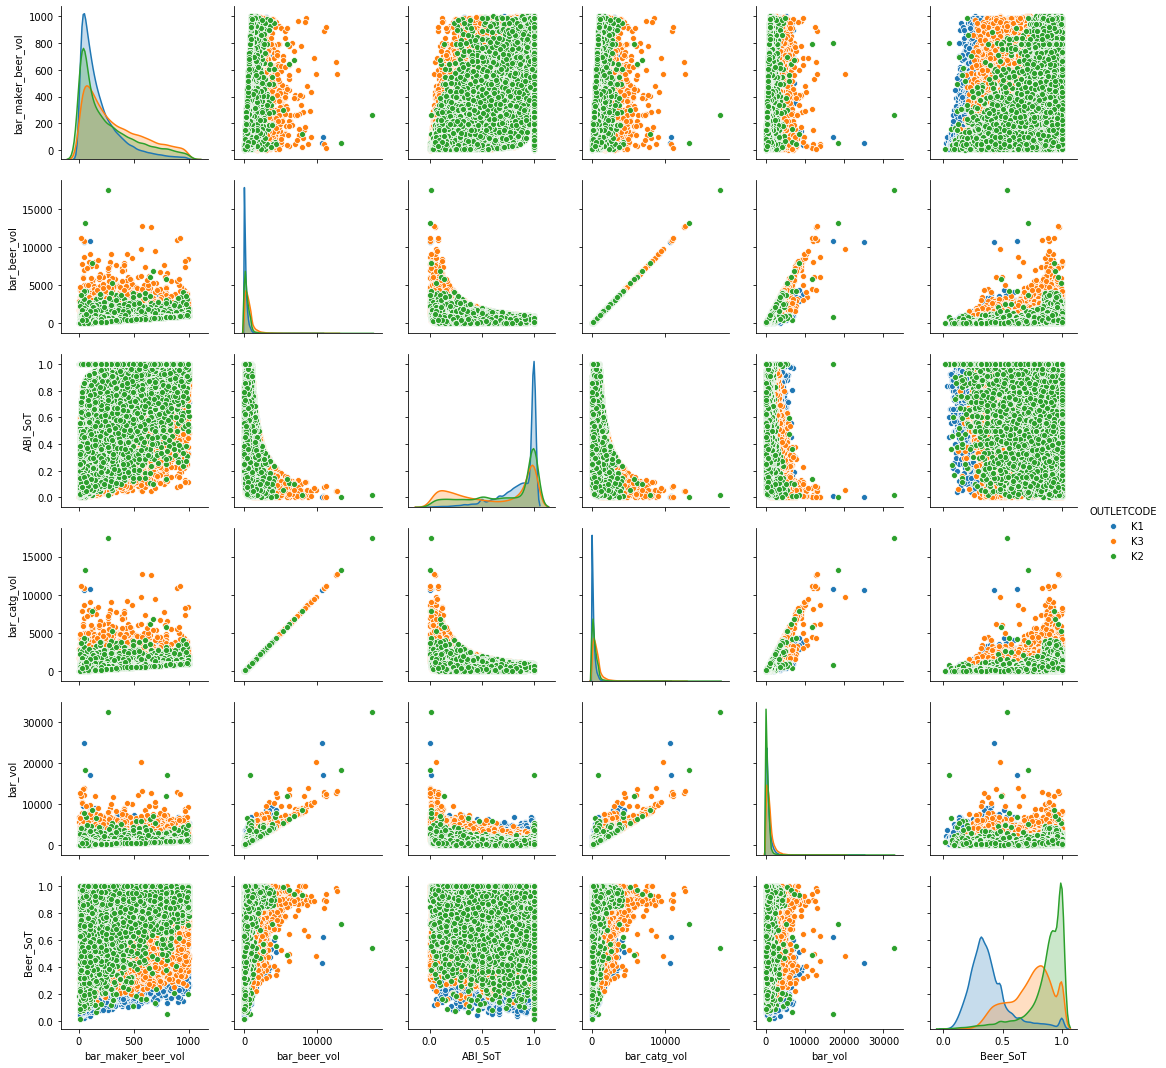

In [11]:
import seaborn as sns
df = K1_data.iloc[:,variable_list]
sns.pairplot(df, hue="OUTLETCODE")